# Customer Segmentation

## Background

This dataset contains all purchases made for an online retail company based in the UK during an eight month period. We could use cluster analysis combined with RFM analysis to do a customer segmentation.

Segmentation : divide our customers up based on common characteristics (demographics, behavior, etc). example Gen Z, Millenial, baby boomer.
---
Recency (R) : aktifitas terbaru. contoh terakhir kali memesan ojek (gojek), terakhir kali belanja (tokped). dll. Satuannya adalah waktu.
---
Frequency (F) : Frequency, seberapa sering. Satuannya adalah kuantitas (count).
---
Monetary (M) : berapa uang yg dibelanjakan (e-Commerce), ongkos yg dikeluarkan (gojek), dll. Satuannya adalah uang. (seberapa banyak).

## Prepare and Explore the Data

For this experiment, we will use [this](https://www.kaggle.com/vijayuv/onlineretail) data from Kaggle platform.

In [ ]:
# Package imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', None)

In [ ]:
# Load data
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Since we want to segment our customers, we have to make sure that `CustomerID` is not null.

In [ ]:
print("Total Data : ", len(df))

Total Data :  541909


In [ ]:
# Check missing value
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
135080/541909

0.249266943342886

We could see that there is missing value in `CustomerID` columns. We could remove those missing values.

In [ ]:
# Remove missing value
df = df[df["CustomerID"].notna()]

df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Then we could do some descriptive statistic.

In [ ]:
# Simple descriptive statistic
df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


Wait, hold on. How come the quantity is a negative number and the unit price is zero? Let's check it.

In [ ]:
# Check anomaly data
quantity_zero = len(df[df["Quantity"] <= 0])
perc_quantity_zero = (len(df[df["Quantity"] <= 0]) / len(df)) * 100
unitprice_zero = len(df[df["UnitPrice"] == 0])
perc_unitprice_zero = (len(df[df["UnitPrice"] == 0]) / len(df)) * 100

print("The data consist of", str(quantity_zero), "rows of data with item quantity less/equal than zero.")
print("About {:.2f}% of total data".format(perc_quantity_zero))
print("")
print("The data consist of", str(unitprice_zero), "rows of data with unit price equal to zero.")
print("About {:.2f}% of total data".format(perc_unitprice_zero))

The data consist of 8905 rows of data with item quantity less/equal than zero.
About 2.19% of total data

The data consist of 40 rows of data with unit price equal to zero.
About 0.01% of total data


Then just remove those anomaly data

In [ ]:
# Remove anomaly
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,397884.000000,397884.000000
mean,12.988238,3.116488
std,179.331775,22.097877
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


Now we're good to go. Lets do some data exploration!

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


The data contains 406829 rows and 8 columns, each row represents each item in a purchasement. The columns are:
* `InvoiceNo` - Invoice number, to identify each invoice
* `StockCode` - Stock code, to identify each item in the inventory
* `Description` - Item's description
* `Quantity` - Number of purchased item in each invoice
* `InvoiceDate` - Date of purchasement
* `UnitPrice` - Item's price per unit
* `CustomerID` - Customer's identification number
* `Country` - Customer's country of origin

In [ ]:
# Check unique value
df[['InvoiceNo', 'StockCode', 'CustomerID', 'Country']].nunique()

InvoiceNo     18532
StockCode      3665
CustomerID     4338
Country          37
dtype: int64

There are 18532 purchasements, 3665 unique item purchased, from 4338 customers that came from 37 countries.

As we seen above, there are 37 countries of customer's origin. Since the retail company is based in the UK, we could simplified the country as UK or Non UK

In [ ]:
# using pandas to simplify country origin
#df['Country_isUK'] = df['Country'].apply(lambda x: 'UK' == 'United Kingdom' else 'Non UK')

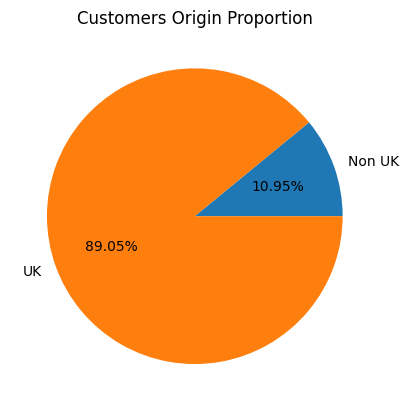

In [ ]:
# Simplify country origin
df['Country_isUK'] = np.where(df['Country']=='United Kingdom', 'UK', 'Non UK')

customers_origin = df.groupby(['Country_isUK']).size()

plt.title('Customers Origin Proportion')
plt.pie(customers_origin, labels=customers_origin.index, autopct=lambda p: f'{p:.2f}%')
plt.show();

Based on the piechart, we could see that mostly our customers are from the UK.

Next, we could analyze the trend of purchasement. First, lets create `TotalAmount` column (`Quantity` * `UnitPrice`). Then, we could transform the `InvoiceDate` data type from string to date.

In [ ]:
# Create new features and cast date column
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_isUK,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,UK,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,UK,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34


Then plot the trendline.

In [ ]:
# agar matplotlib bisa memplot berdasarkan frekuensi waktu yang diinginkan
import matplotlib.dates as mdates

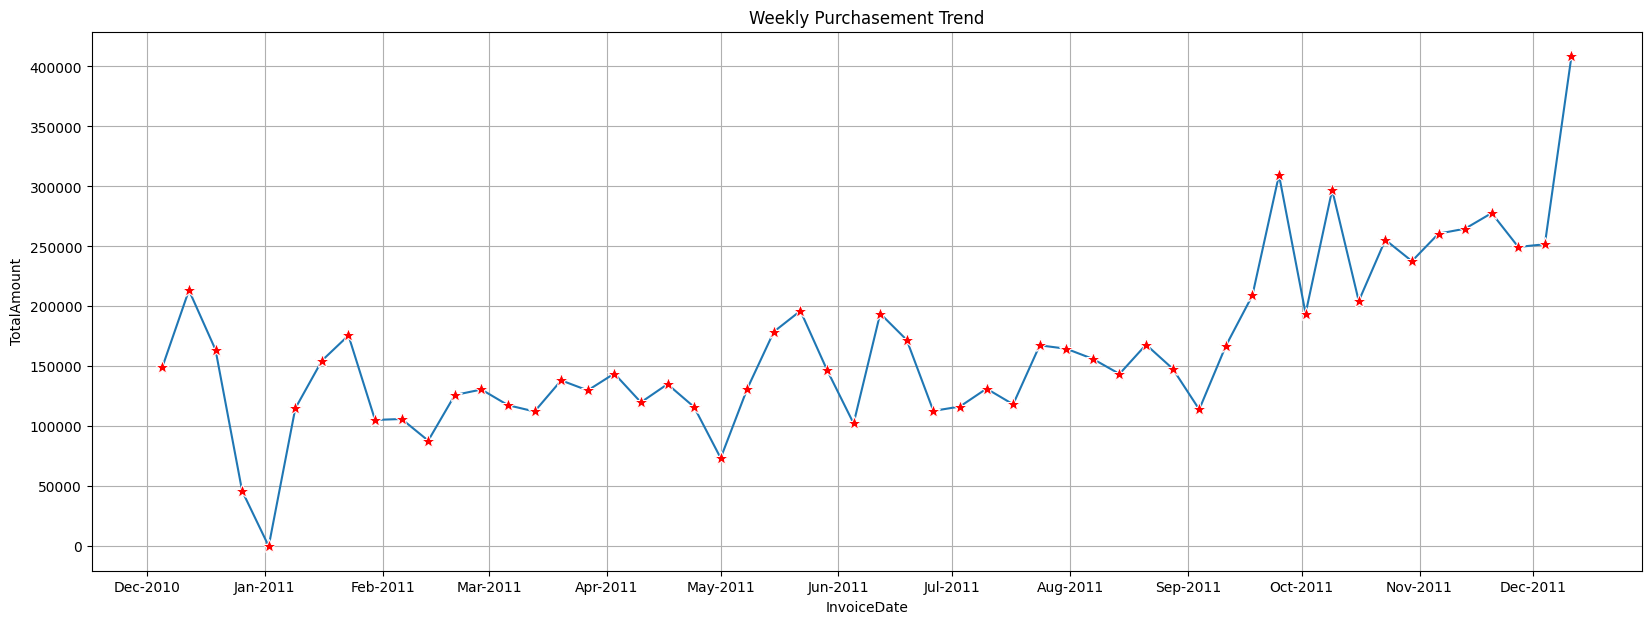

In [ ]:
# Plot weekly trend
weekly_purchasements = df.copy()
weekly_purchasements = weekly_purchasements.groupby(
    by=pd.Grouper(key="InvoiceDate", freq="1W"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Weekly Purchasement Trend')
ax = sns.lineplot(
    x=weekly_purchasements.index,
    y=weekly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

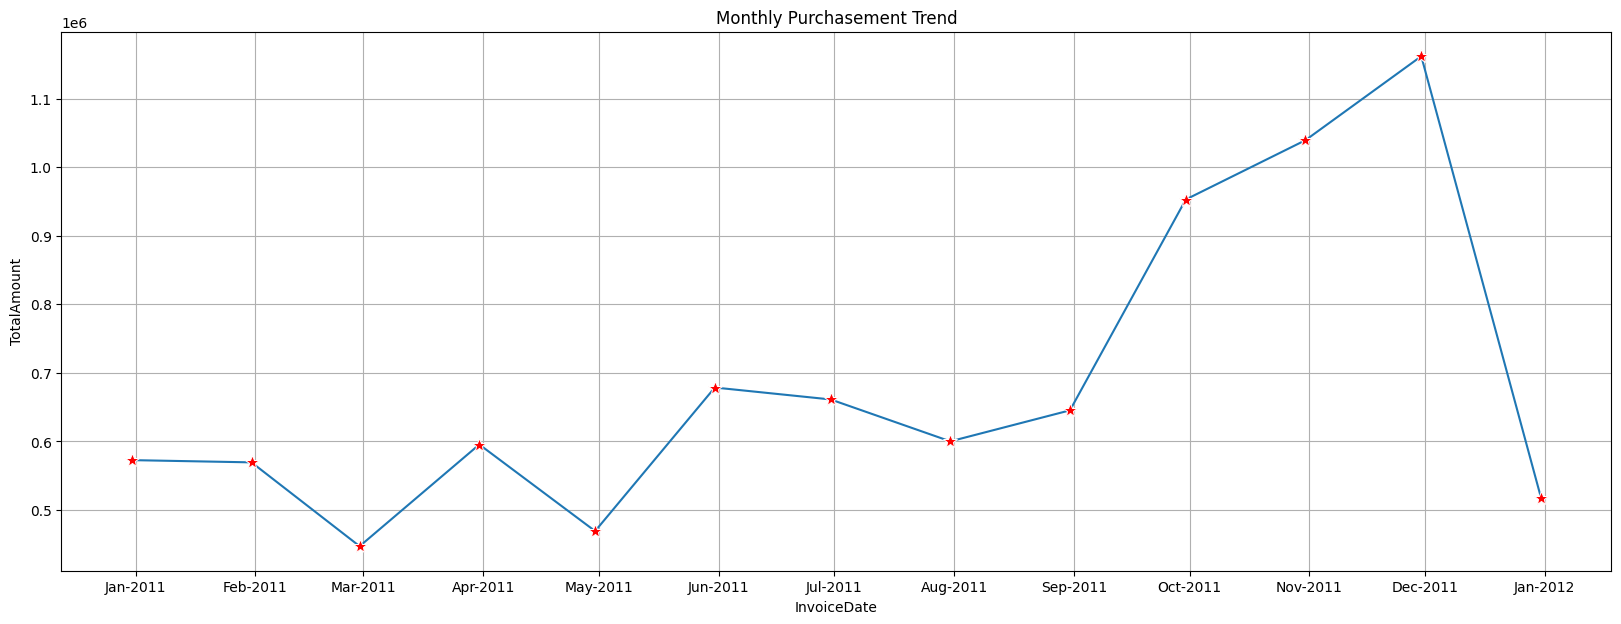

In [ ]:
# Plot monthly trend
monthly_purchasements = df.copy()
monthly_purchasements = monthly_purchasements.groupby(by = pd.Grouper(key="InvoiceDate", freq="1M"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Monthly Purchasement Trend')
ax = sns.lineplot(
    x=monthly_purchasements.index,
    y=monthly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

Based on the picture above, it can be seen that there was an increase in total purchases at the end of the year.

## RFM

In this project, we would segment the customers using customer's demography and purchasement behavior. To explain the customer's demography, we could use `Country` column while to explain the customer's purchasement behavior we have to transform our data first to get those information. We could use RFM analysis to get those information.

### Recency

To measure customer's recency, we could substract the latest transaction date in the data with each customer's latest transaction.

In [ ]:
# Get customer's recency
recency = df.groupby(['CustomerID'])['InvoiceDate'].max()
recency = max(recency) - recency
recency = recency.dt.days
recency = recency.rename('Recency')

recency.head()

CustomerID
12346.0    325
12347.0      1
12348.0     74
12349.0     18
12350.0    309
Name: Recency, dtype: int64

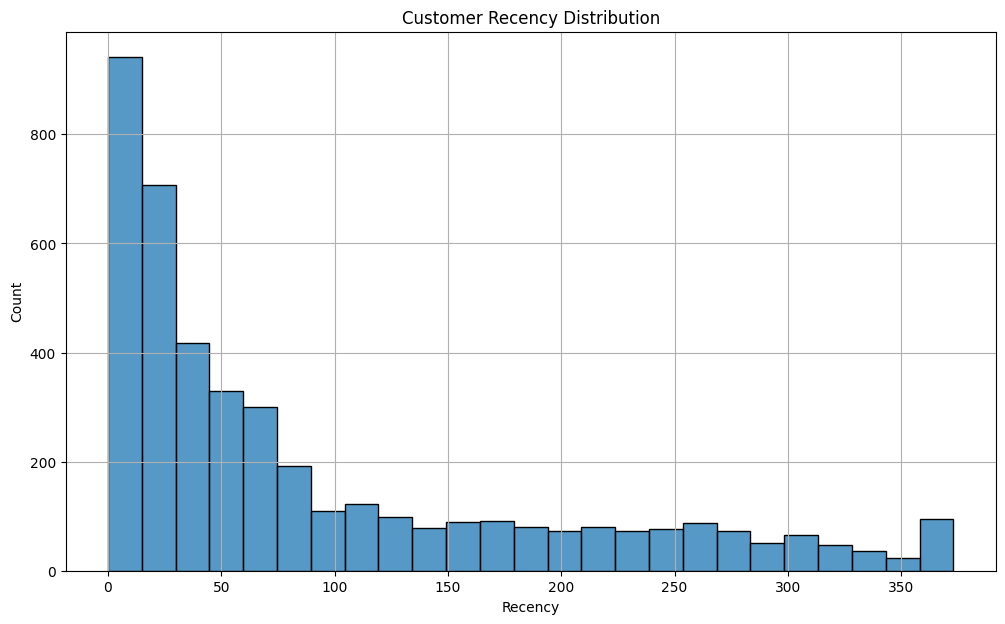

In [ ]:
# Recency histogram plot
plt.figure(figsize=(12, 7))
sns.histplot(recency)
plt.title('Customer Recency Distribution')
plt.grid()
plt.show()

### Frequency

To measure customer's frequency, we could count customer's invoice.

In [ ]:
# Count frequency
frequency = df.groupby(['CustomerID'])['InvoiceNo'].count()
frequency = frequency.rename('Frequency')
frequency.head()

CustomerID
12346.0      1
12347.0    182
12348.0     31
12349.0     73
12350.0     17
Name: Frequency, dtype: int64

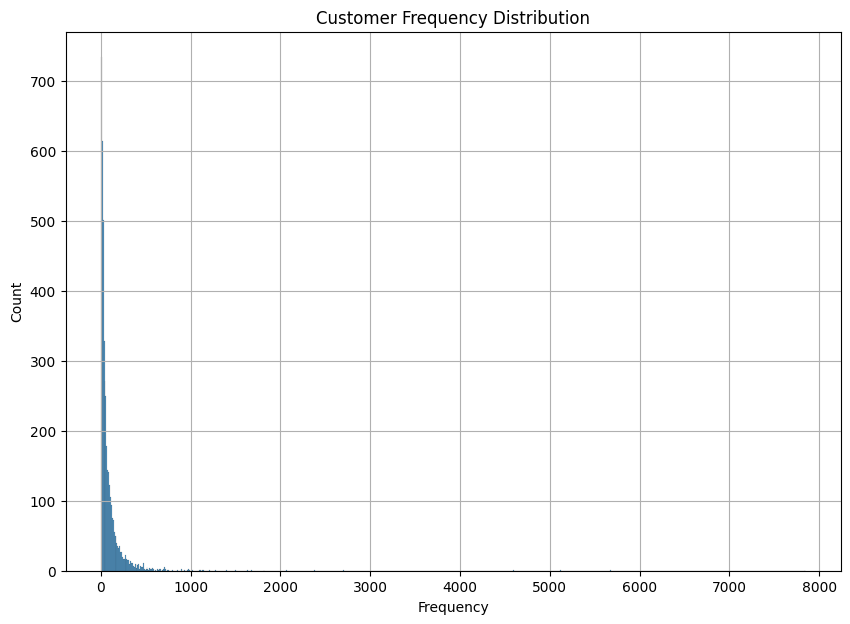

In [ ]:
# Frequency histogram plot
plt.figure(figsize=(10, 7))
plt.title('Customer Frequency Distribution')
sns.histplot(frequency)
plt.grid()
plt.show();

### Monetary

To measure customer's monetary, we could sum the customer's total purchasements.

In [ ]:
# Sum the money spent
monetary = df.groupby(['CustomerID'])['TotalAmount'].sum()
monetary = monetary.rename('Monetary')
monetary.head()

CustomerID
12346.0    77183.60
12347.0     4310.00
12348.0     1797.24
12349.0     1757.55
12350.0      334.40
Name: Monetary, dtype: float64

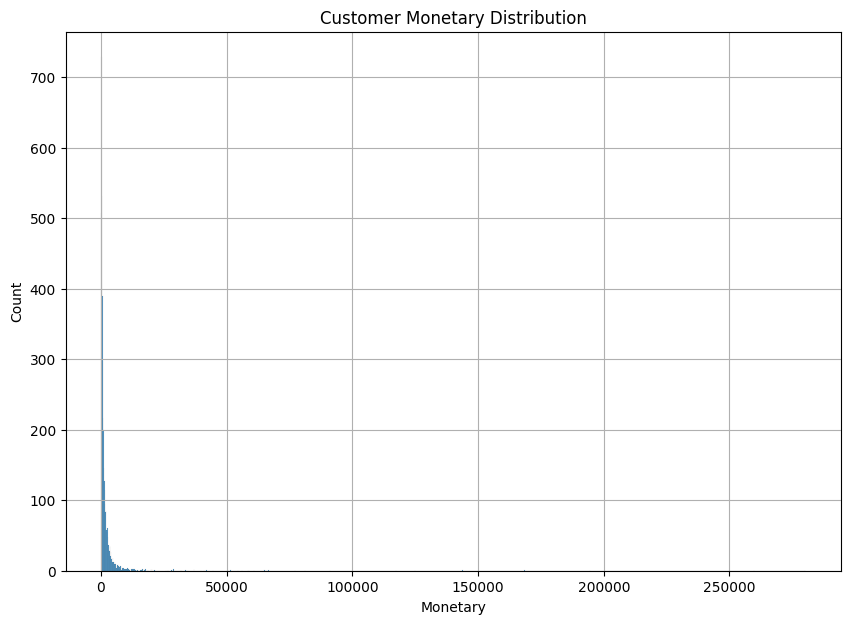

In [ ]:
# Monetary histogram plot
plt.figure(figsize=(10, 7))
plt.title('Customer Monetary Distribution')
sns.histplot(monetary)
plt.grid()
plt.show()

### Merge the Data

The data could be separated into two dataframes. The first dataframe (log transformed data) supposed to be used when modeling and the second one (without log transformation) could be used when visualize the result.

In [ ]:
# Get customer's country of origin
country = (
    df.groupby(['CustomerID', 'Country_isUK'])
    .size()
    .reset_index()
    .drop(0, axis=1)
)

# Merge the data
df_new = (
    country
    .merge(recency, on='CustomerID')
    .merge(frequency, on='CustomerID')
    .merge(monetary, on='CustomerID')
)

# Set CustomerID as index
df_new = df_new.set_index('CustomerID')
df_new.head()

,Country_isUK,Recency,Frequency,Monetary
CustomerID,,,,
12346.0,UK,325,1,77183.60
12347.0,Non UK,1,182,4310.00
12348.0,Non UK,74,31,1797.24
12349.0,Non UK,18,73,1757.55
12350.0,Non UK,309,17,334.40


### One Hot Encoding

Since our model could just accept the numeric value, we have to recode the non numeric column.

In [ ]:
# Recode the non numeric variable

df_new = pd.get_dummies(
    df_new,
    columns=['Country_isUK'],
    drop_first=True
)

df_new = df_new.rename(
    columns={'Country_isUK_UK': 'Country_UK'}
)

df_new.head()

,Recency,Frequency,Monetary,Country_UK
CustomerID,,,,
12346.0,325,1,77183.60,1
12347.0,1,182,4310.00,0
12348.0,74,31,1797.24,0
12349.0,18,73,1757.55,0
12350.0,309,17,334.40,0


### Scaling

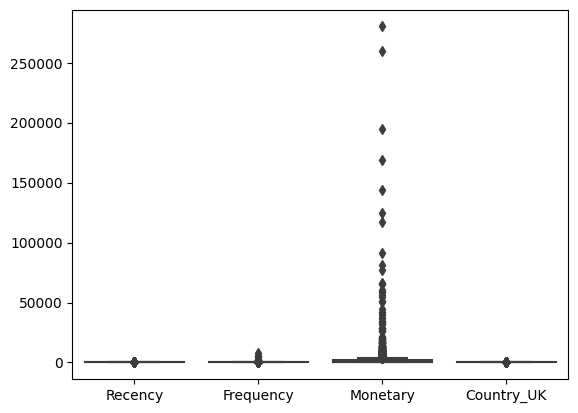

In [ ]:
sns.boxplot(data=df_new)
plt.show()

As we could see, there are variation of range in each column. We have to standardize it first.

In [ ]:
# Scale the data

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_new)

df_scaled = pd.DataFrame(
    df_scaled,
    columns=df_new.columns,
    index=df_new.index
)

df_scaled.head()

,Recency,Frequency,Monetary,Country_UK
CustomerID,,,,
12346.0,2.334574,-0.396578,8.358668,0.326547
12347.0,-0.905340,0.394649,0.250966,-3.062350
12348.0,-0.175360,-0.265435,-0.028596,-3.062350
12349.0,-0.735345,-0.081836,-0.033012,-3.062350
12350.0,2.174578,-0.326635,-0.191347,-3.062350


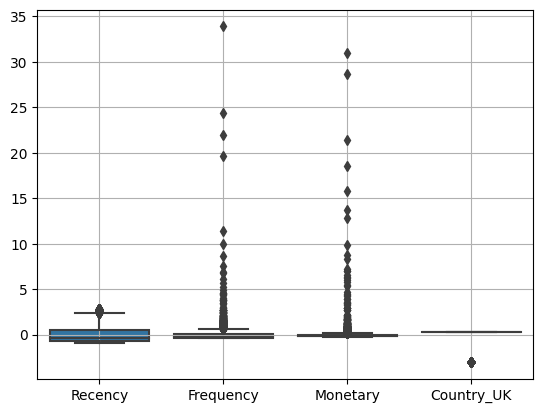

In [ ]:
# Plot scaled data
sns.boxplot(data = df_scaled)
plt.grid()
plt.show()

## Modeling

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Modeling
possible_k = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette = [] # makin tinggi makin bagus

for k in possible_k:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_scaled)
    silhouette.append(silhouette_score(X=df_scaled, labels=kmeans.labels_))

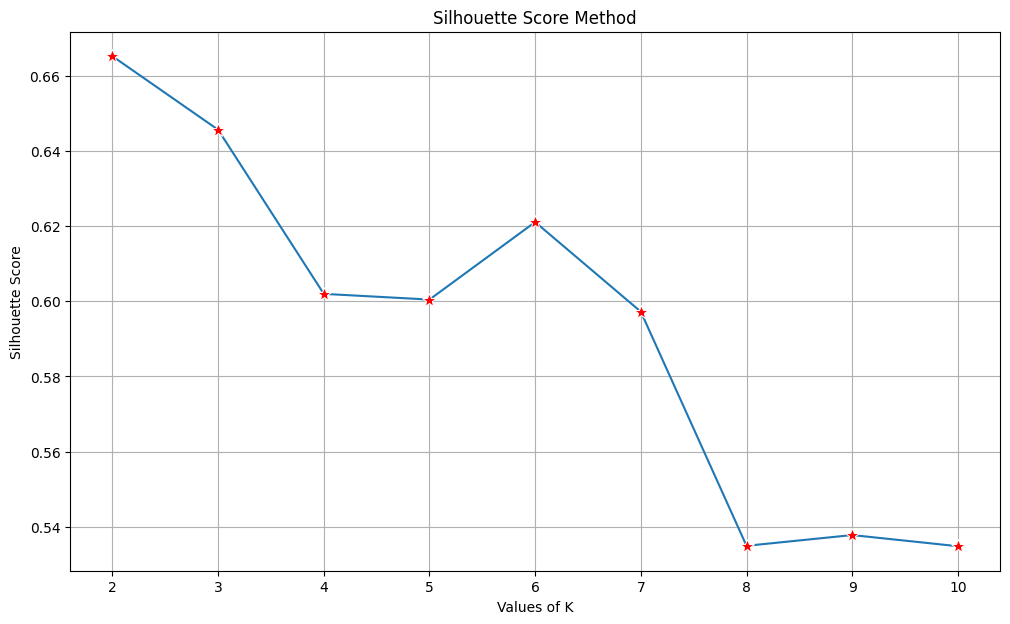

In [ ]:
# Plot the score
plt.figure(figsize=(12, 7))
sns.lineplot(
    x=possible_k,
    y=silhouette,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.grid()
plt.show();

Using silhouette score, the best K is either 2 or 6

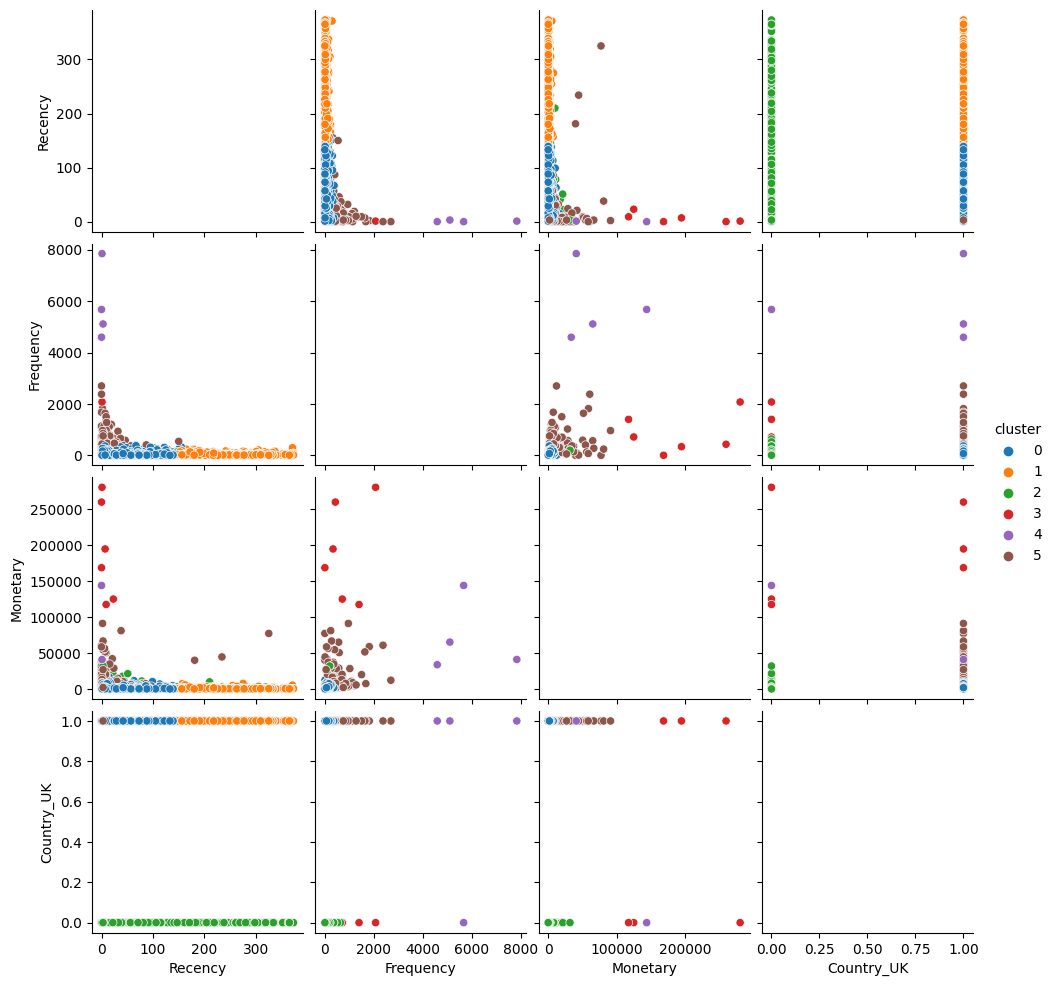

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=42).fit(df_scaled)

df_result_kmeans = df_new.copy()
df_result_kmeans['cluster'] = kmeans.labels_

sns.pairplot(
    data=df_result_kmeans,
    hue='cluster',
    diag_kind='None',
    palette='tab10'
)

plt.show();

In [ ]:
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
(
    df_result_kmeans
    .drop("Country_UK", axis = 1)
    .groupby('cluster')
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max'])
    .transpose()
)

cluster                      0            1             2              3  \
Recency   mean       42.676884   246.776618     95.405797       6.666667   
          std        36.313016    65.636727    104.638705       8.869423   
          min         0.000000   143.000000      0.000000       0.000000   
          q25        14.000000   189.000000     18.000000       0.250000   
          median     31.000000   242.000000     52.000000       4.000000   
          q75        64.000000   296.000000    136.500000       8.500000   
          max       155.000000   373.000000    373.000000      23.000000   
Frequency mean       76.270826    27.689979     81.396135     826.833333   
          std        74.030983    32.176026     96.304061     771.620481   
          min         1.000000     1.000000      1.000000       3.000000   
          q25        22.000000     8.250000     21.250000     360.500000   
          median     51.000000    18.000000     45.000000     572.500000   
          q75       107.000000    33.000000    101.000000    1228.500000   
          max       385.000000   297.000000    638.000000    2076.000000   
Monetary  mean     1341.293935   450.793070   2262.538913  190863.461667   
          std      1592.871914   610.367153   3479.689136   67791.993010   
          min         6.200000     3.750000     51.560000  117379.630000   
          q25       371.700000   163.225000    459.650000  135804.022500   
          median    795.120000   305.515000   1025.700000  181511.645000   
          q75      1720.300000   505.542500   2659.962500  243380.672500   
          max     17654.540000  7832.470000  31906.820000  280206.020000   

cluster                       4             5  
Recency   mean         1.000000     15.234973  
          std          1.414214     35.305176  
          min          0.000000      0.000000  
          q25          0.000000      2.000000  
          median       0.500000      6.000000  
          q75          1.500000     16.000000  
          max          3.000000    325.000000  
Frequency mean      5807.000000    535.360656  
          std       1429.730044    358.078267  
          min       4595.000000      1.000000  
          q25       4982.000000    367.000000  
          median    5393.000000    450.000000  
          q75       6218.000000    589.500000  
          max       7847.000000   2700.000000  
Monetary  mean     70925.287500  13085.065738  
          std      50424.336433  16313.461152  
          min      33719.730000   1093.650000  
          q25      39173.610000   4014.945000  
          median   53078.180000   6923.130000  
          q75      84829.857500  13213.210000  
          max     143825.060000  91062.380000

In [ ]:
df.CustomerID.nunique()

4338

In [ ]:
df_result_kmeans.head(10)

,Recency,Frequency,Monetary,Country_UK,cluster
CustomerID,,,,,
12346.0,325,1,77183.60,1,5
12347.0,1,182,4310.00,0,2
12348.0,74,31,1797.24,0,2
12349.0,18,73,1757.55,0,2
12350.0,309,17,334.40,0,2
12352.0,35,85,2506.04,0,2
12353.0,203,4,89.00,0,2
12354.0,231,58,1079.40,0,2
12355.0,213,13,459.40,0,2


In [ ]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Recency"].count()

cluster  Country_UK
0        1             2773
1        1              958
2        0              414
3        0                3
         1                3
4        0                1
         1                3
5        1              183
Name: Recency, dtype: int64

That's it! The customer's behavior really segmented by their country of origin.

What if we separate the customer by its country of origin before doing cluster analysis?

# Question

1. (30 point) Lakukan EDA lebih mendalam dari data yang tersedia. Misalnya: a) Siapa top 5 customer dengan pembelian terbanyak? b) Kapan waktu pembelian dengan jumlah customer terbanyak? (Misal hari apa, jam berapa, bulan apa, minggu ke berapa, dst). EDA juga bisa dilakukan menggunakan business question lain.
2. (30 point) Apa karakteristik/ciri utama dari masing-masing cluster? Apa promo yang kira-kira cocok untuk diberikan ke masing-masing cluster?
3. (40 point) Bagaimana jika segmentation difokuskan untuk customer di luar UK? Apakah terdapat insight yang menarik? Apa karakteristik utama dari cluster-cluster non UK?

# EDA

## Top 5 Customer by monetary

In [ ]:
df_result_kmeans.nlargest(n=5, columns='Monetary')

,Recency,Frequency,Monetary,Country_UK,cluster
CustomerID,,,,,
14646.0,1,2076,280206.02,0,3
18102.0,0,431,259657.30,1,3
17450.0,7,337,194550.79,1,3
16446.0,0,3,168472.50,1,3
14911.0,0,5675,143825.06,0,4


## Weekly Purchasement

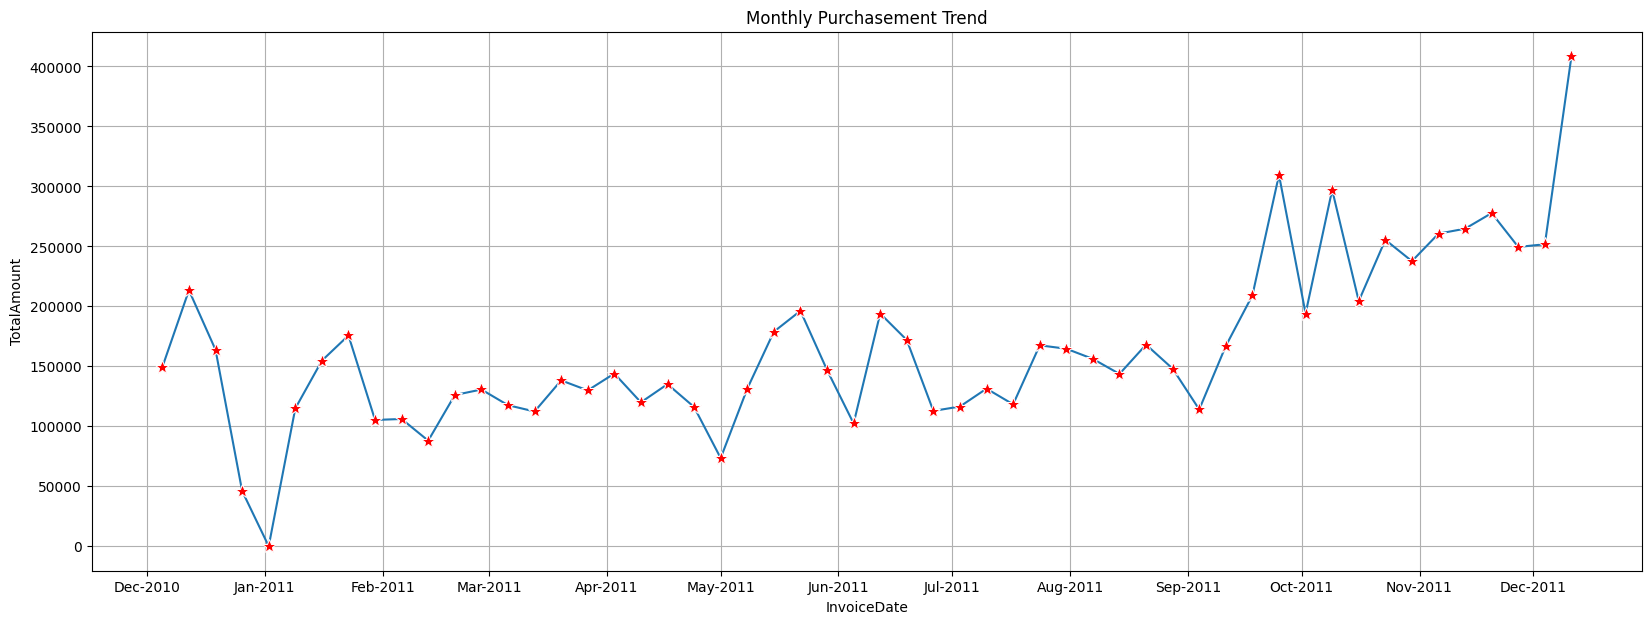

In [ ]:
# Plot weekly trend
weekly_purchasements = df.copy()
weekly_purchasements = weekly_purchasements.groupby(by = pd.Grouper(key="InvoiceDate", freq="1W"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Monthly Purchasement Trend')
ax = sns.lineplot(
    x=weekly_purchasements.index,
    y=weekly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

mayoritas penjualan mengalami kenaikan pada akhir bulan, sedangkan pada pertengahan bulan mayoritas mengalami penurunan

# Cluster Characteristic

<ipython-input-39-5b48fee38d59>:8: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(x=df_result_kmeans.columns[i], y=df_result_kmeans.columns[j], hue='cluster', data=df_result_kmeans, palette=palette)


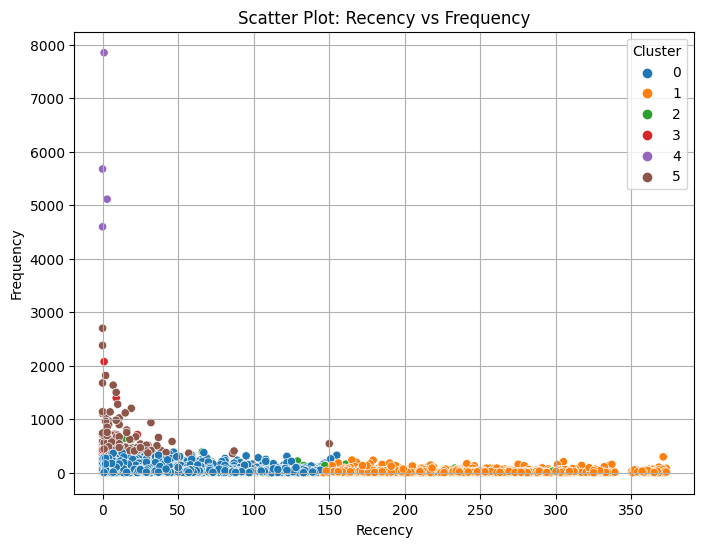

<ipython-input-39-5b48fee38d59>:8: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(x=df_result_kmeans.columns[i], y=df_result_kmeans.columns[j], hue='cluster', data=df_result_kmeans, palette=palette)


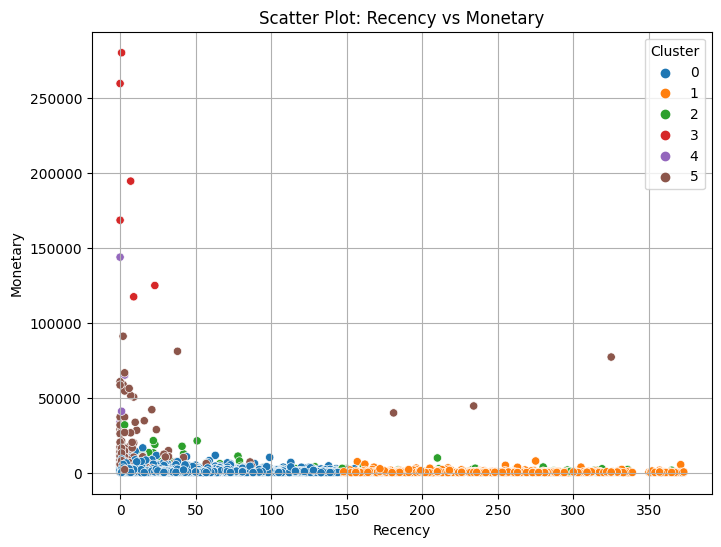

<ipython-input-39-5b48fee38d59>:8: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(x=df_result_kmeans.columns[i], y=df_result_kmeans.columns[j], hue='cluster', data=df_result_kmeans, palette=palette)


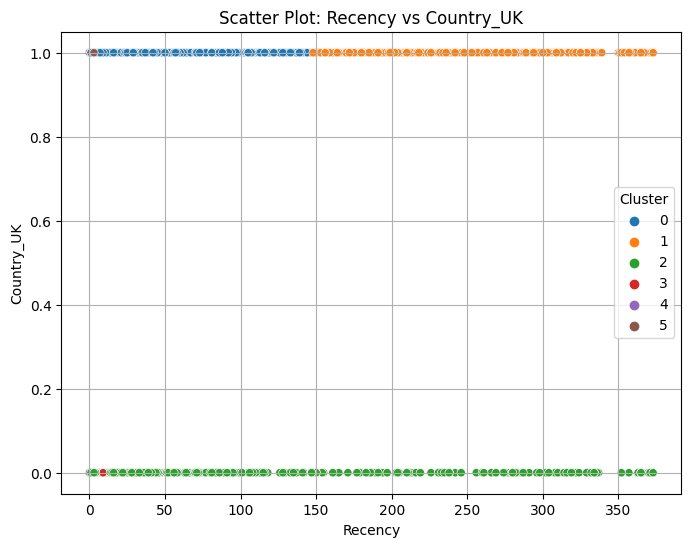

<ipython-input-39-5b48fee38d59>:8: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(x=df_result_kmeans.columns[i], y=df_result_kmeans.columns[j], hue='cluster', data=df_result_kmeans, palette=palette)


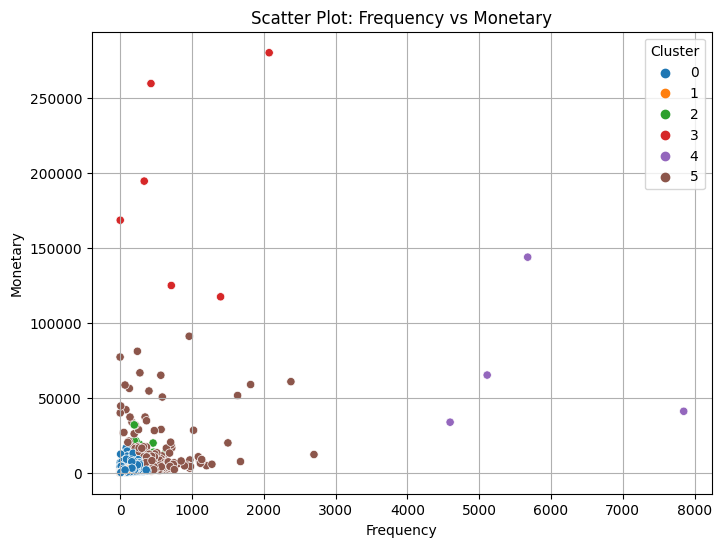

<ipython-input-39-5b48fee38d59>:8: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(x=df_result_kmeans.columns[i], y=df_result_kmeans.columns[j], hue='cluster', data=df_result_kmeans, palette=palette)


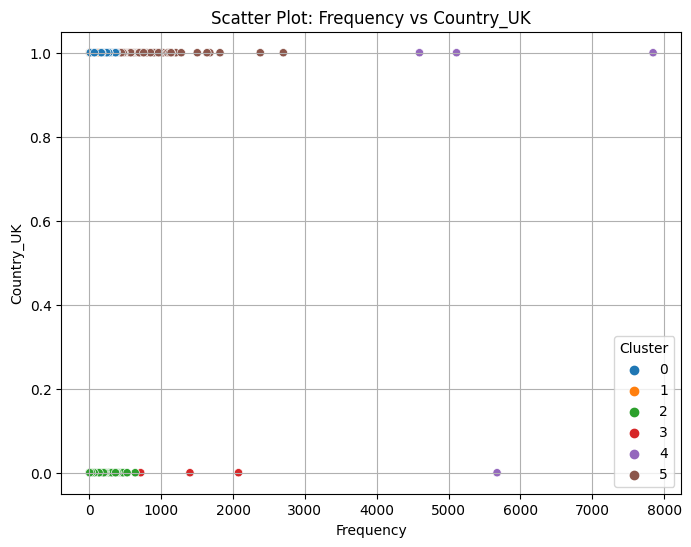

<ipython-input-39-5b48fee38d59>:8: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(x=df_result_kmeans.columns[i], y=df_result_kmeans.columns[j], hue='cluster', data=df_result_kmeans, palette=palette)


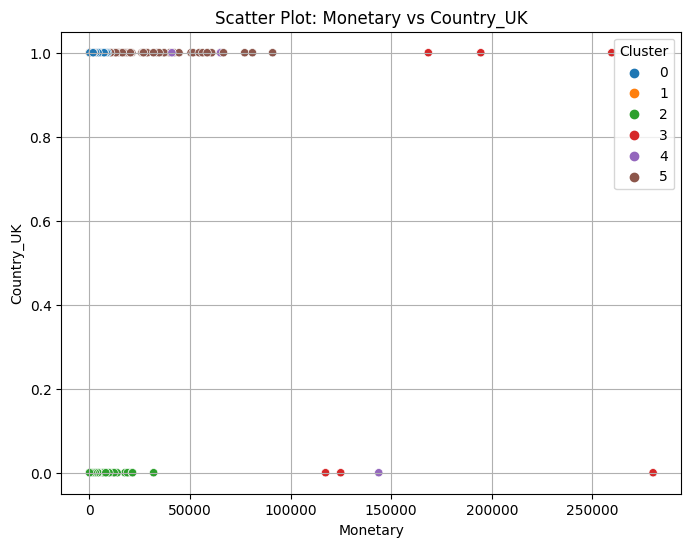

In [ ]:
# Mengatur palette untuk warna plot
palette = sns.color_palette('tab10')

# Membuat scatter plot untuk setiap kombinasi dua fitur
for i in range(len(df_result_kmeans.columns) - 1):
    for j in range(i + 1, len(df_result_kmeans.columns) - 1):
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=df_result_kmeans.columns[i], y=df_result_kmeans.columns[j], hue='cluster', data=df_result_kmeans, palette=palette)
        plt.title(f'Scatter Plot: {df_result_kmeans.columns[i]} vs {df_result_kmeans.columns[j]}')
        plt.xlabel(df_result_kmeans.columns[i])
        plt.ylabel(df_result_kmeans.columns[j])
        plt.grid(True)
        plt.legend(title='Cluster', loc='best')
        plt.show()

In [ ]:
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
(
    df_result_kmeans
    .drop("Country_UK", axis = 1)
    .groupby('cluster')
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max'])
    .transpose()
)

cluster                      0            1             2              3  \
Recency   mean       42.676884   246.776618     95.405797       6.666667   
          std        36.313016    65.636727    104.638705       8.869423   
          min         0.000000   143.000000      0.000000       0.000000   
          q25        14.000000   189.000000     18.000000       0.250000   
          median     31.000000   242.000000     52.000000       4.000000   
          q75        64.000000   296.000000    136.500000       8.500000   
          max       155.000000   373.000000    373.000000      23.000000   
Frequency mean       76.270826    27.689979     81.396135     826.833333   
          std        74.030983    32.176026     96.304061     771.620481   
          min         1.000000     1.000000      1.000000       3.000000   
          q25        22.000000     8.250000     21.250000     360.500000   
          median     51.000000    18.000000     45.000000     572.500000   
          q75       107.000000    33.000000    101.000000    1228.500000   
          max       385.000000   297.000000    638.000000    2076.000000   
Monetary  mean     1341.293935   450.793070   2262.538913  190863.461667   
          std      1592.871914   610.367153   3479.689136   67791.993010   
          min         6.200000     3.750000     51.560000  117379.630000   
          q25       371.700000   163.225000    459.650000  135804.022500   
          median    795.120000   305.515000   1025.700000  181511.645000   
          q75      1720.300000   505.542500   2659.962500  243380.672500   
          max     17654.540000  7832.470000  31906.820000  280206.020000   

cluster                       4             5  
Recency   mean         1.000000     15.234973  
          std          1.414214     35.305176  
          min          0.000000      0.000000  
          q25          0.000000      2.000000  
          median       0.500000      6.000000  
          q75          1.500000     16.000000  
          max          3.000000    325.000000  
Frequency mean      5807.000000    535.360656  
          std       1429.730044    358.078267  
          min       4595.000000      1.000000  
          q25       4982.000000    367.000000  
          median    5393.000000    450.000000  
          q75       6218.000000    589.500000  
          max       7847.000000   2700.000000  
Monetary  mean     70925.287500  13085.065738  
          std      50424.336433  16313.461152  
          min      33719.730000   1093.650000  
          q25      39173.610000   4014.945000  
          median   53078.180000   6923.130000  
          q75      84829.857500  13213.210000  
          max     143825.060000  91062.380000

*   0 : recency cukup besar, freq terkecil ke 2, monetary terkecil ke 2. (Low - Spenders). Marketing strategy : Targeted promotions and discounts to encourage more frequent and higher spending.

*   1 : recency sangat besar, freq terkecil, monetary terkecil (Inactive). Marketing Strategy: Re-engage these customers with personalized offers and incentives to encourage them to make a purchase.
*   2 : recency besar, freq terkecil ke 3, monetary terkecil ke 3 (Occasional Buyers). Marketing Strategy: Create loyalty programs and special offers to entice them to make more purchases.


*   3 : recency bagus, freq tertinggi ke 2, monetary paling tinggi (Regular Buyers). Marketing Strategy: Offer personalized recommendations and exclusive deals to enhance customer loyalty.

*   4 : recency paling bagus, freq paling bagus, monetary terbesar ke 2 (High-value Customers). Marketing Strategy: Provide VIP treatment, exclusive rewards, and personalized services to maintain their loyalty.
*   5 : recency cukup bagus, freq terbesar ke 3, monetary terbesar ke 3 (Potential High-Spenders). Marketing Strategy: Offer personalized product recommendations and targeted campaigns to encourage higher spending.





# Clustering for non UK

In [ ]:
non_uk = df_new[df_new['Country_UK']==0]

non_uk.head(10)

,Recency,Frequency,Monetary,Country_UK
CustomerID,,,,
12347.0,1,182,4310.00,0
12348.0,74,31,1797.24,0
12349.0,18,73,1757.55,0
12350.0,309,17,334.40,0
12352.0,35,85,2506.04,0
12353.0,203,4,89.00,0
12354.0,231,58,1079.40,0
12355.0,213,13,459.40,0
12356.0,22,59,2811.43,0


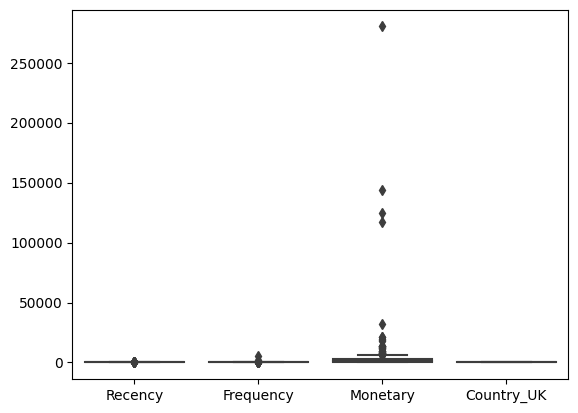

In [ ]:
sns.boxplot(data=non_uk)
plt.show()

In [ ]:
#scaling
scaler = StandardScaler()
df_scaled_non = scaler.fit_transform(non_uk)

df_scaled_non = pd.DataFrame(
    df_scaled_non,
    columns=non_uk.columns,
    index=non_uk.index
)

df_scaled_non.head()

,Recency,Frequency,Monetary,Country_UK
CustomerID,,,,
12347.0,-0.896621,0.248302,0.026983,0.0
12348.0,-0.197122,-0.233730,-0.115746,0.0
12349.0,-0.733724,-0.099655,-0.118001,0.0
12350.0,2.054690,-0.278422,-0.198838,0.0
12352.0,-0.570827,-0.061348,-0.075485,0.0


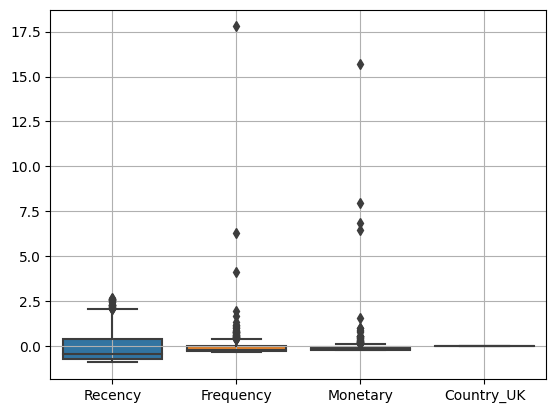

In [ ]:
# Plot scaled data
sns.boxplot(data = df_scaled_non)
plt.grid()
plt.show()

In [ ]:
# Modeling
possible_k = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette = [] # makin tinggi makin bagus

for k in possible_k:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_scaled_non)
    silhouette.append(silhouette_score(X=df_scaled_non, labels=kmeans.labels_))

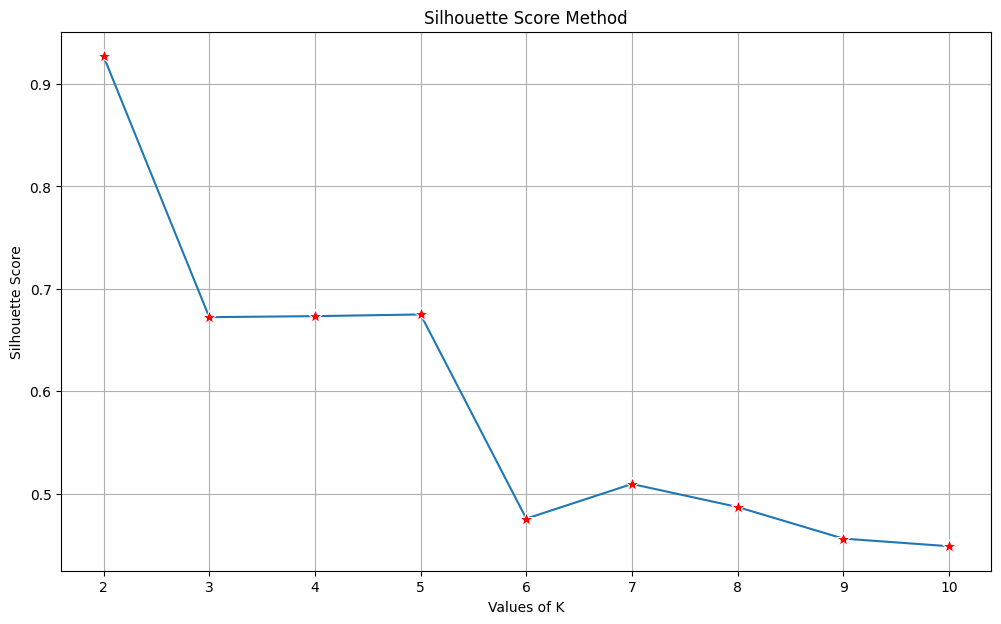

In [ ]:
# Plot the score
plt.figure(figsize=(12, 7))
sns.lineplot(
    x=possible_k,
    y=silhouette,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.grid()
plt.show();

Using silhouette score, the best k is 3

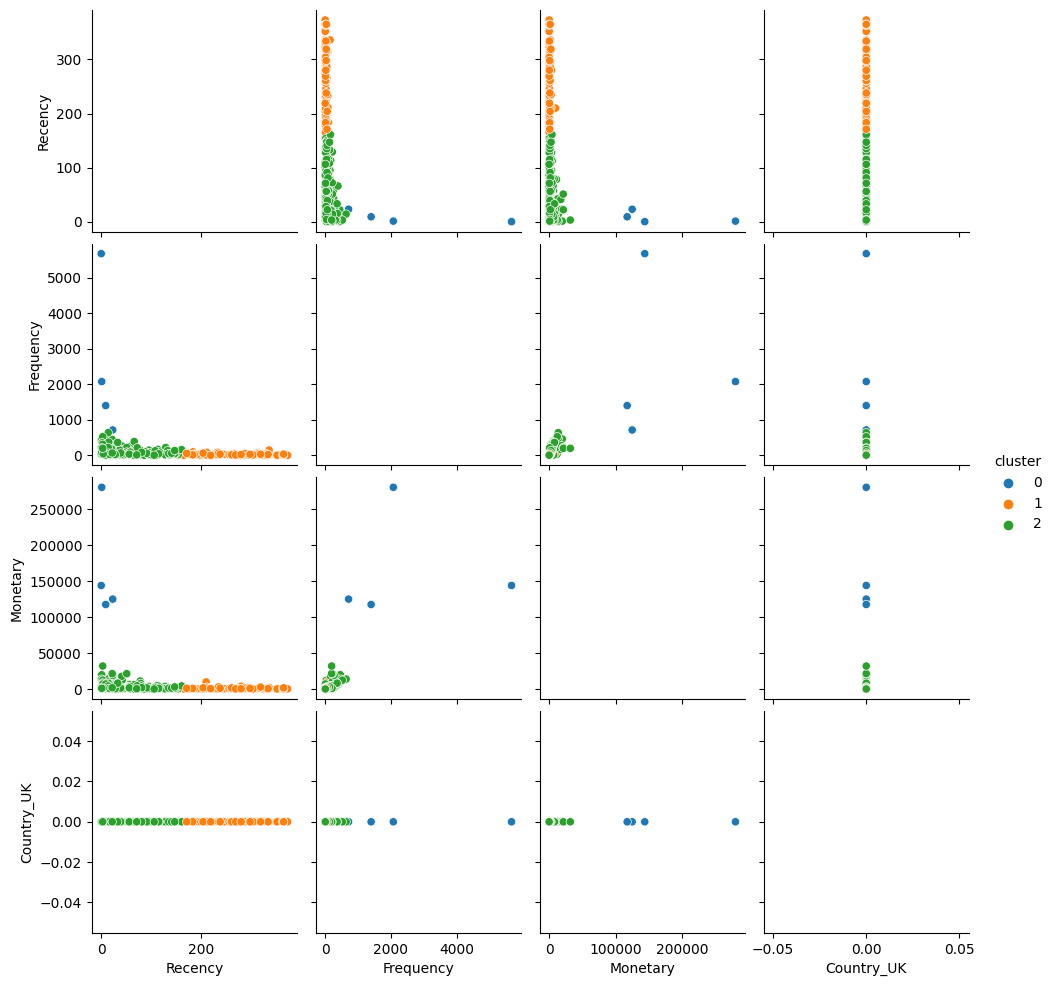

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(df_scaled_non)

df_cluster_non = non_uk.copy()
df_cluster_non['cluster'] = kmeans.labels_

sns.pairplot(
    data=df_cluster_non,
    hue='cluster',
    diag_kind='None',
    palette='tab10'
)

plt.show();

In [ ]:
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
(
    df_cluster_non
    .drop("Country_UK", axis = 1)
    .groupby('cluster')
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max'])
    .transpose()
)

cluster                       0            1             2
Recency   mean         8.250000   272.582418     45.489164
          std         10.626225    60.647445     40.554109
          min          0.000000   162.000000      0.000000
          q25          0.750000   222.500000     14.500000
          median       5.000000   280.000000     31.000000
          q75         12.500000   317.500000     71.000000
          max         23.000000   373.000000    161.000000
Frequency mean      2466.250000    25.604396     97.114551
          std       2210.251928    23.982345    102.991478
          min        714.000000     1.000000      2.000000
          q25       1228.500000    11.000000     31.000000
          median    1738.000000    21.000000     59.000000
          q75       2975.750000    30.000000    125.500000
          max       5675.000000   149.000000    638.000000
Monetary  mean    166581.310000   796.186593   2675.659845
          std      76562.278586  1201.683175   3787.829719
          min     117379.630000    63.000000     51.560000
          q25     123030.805000   225.750000    611.405000
          median  134369.795000   433.740000   1298.040000
          q75     177920.300000   851.870000   3341.300000
          max     280206.020000  9864.260000  31906.820000

In [ ]:
df_cluster_non.head(5)

,Recency,Frequency,Monetary,Country_UK,cluster
CustomerID,,,,,
12347.0,1,182,4310.00,0,2
12348.0,74,31,1797.24,0,2
12349.0,18,73,1757.55,0,2
12350.0,309,17,334.40,0,1
12352.0,35,85,2506.04,0,2


In [ ]:
df_cluster_non['cluster'] = df_cluster_non['cluster'].astype(str)

df_cluster_non.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 418 entries, 12347.0 to 17844.0
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Recency     418 non-null    int64  
 1   Frequency   418 non-null    int64  
 2   Monetary    418 non-null    float64
 3   Country_UK  418 non-null    uint8  
 4   cluster     418 non-null    object 
dtypes: float64(1), int64(2), object(1), uint8(1)
memory usage: 16.7+ KB


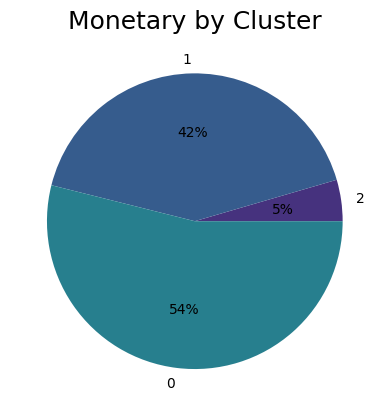

In [ ]:
# sum by cluster
cluster_sum = df_cluster_non.groupby('cluster')['Monetary'].sum().sort_values()

data = cluster_sum #data
keys = df_cluster_non['cluster'].unique() #label

#define seaborn color palette to use
palette_color = sns.color_palette("viridis")

#plotting data on chart
plt.pie(data, labels=keys, colors=palette_color, autopct='%.0f%%')
plt.title(f"Monetary by Cluster", fontsize=18)

#displaying chart
plt.show()


- cluster 0 : recency rendah, frequency tinggi, monetary tinggi (**High-value Customers**)
- cluster 1 : recency sangat tinggi, frequency sangat rendah, monetary sangat rendah (**Inactive Customers**)
- cluster 2 : recency moderat, frequency moderat, monetary moderat (**Moderate Customers**)